<a href="https://colab.research.google.com/github/woranov/amlta-project/blob/main/notebooks/tapas_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import amlta  # noqa: F401
except ImportError:
    %pip install -q --no-dependencies -U git+https://github.com/woranov/amlta-project.git
    %pip install -q lightning

In [2]:
from pathlib import Path

try:
    from google.colab import drive  # pyright: ignore[reportMissingImports]

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from amlta.config import config

In [3]:
if IN_COLAB:
    mount_point = Path("/content/drive")
    drive_path = mount_point / "MyDrive"

    # edit
    data_dir = drive_path / "uni" / "ws2425" / "amlta" / "project" / "data"

    config.update(data_dir=data_dir)

    if not mount_point.exists():
        drive.mount(str(mount_point))

In [ ]:
import functools
import importlib
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.tuner import Tuner
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import TapasConfig, TapasForQuestionAnswering, TapasTokenizer

from amlta.probas import flows, processes
from amlta.tapas.preprocessing import transform_flows_for_tapas

processes = importlib.reload(processes)

In [44]:
tapas_config = TapasConfig.from_pretrained(
    "google/tapas-base-finetuned-wikisql-supervised"
)
tapas_model = TapasForQuestionAnswering.from_pretrained(
    "google/tapas-base-finetuned-wikisql-supervised", config=tapas_config
)
tapas_tokenizer = TapasTokenizer.from_pretrained(
    "google/tapas-base-finetuned-wikisql-supervised"
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tapas_model.to(device)

TapasForQuestionAnswering(
  (tapas): TapasModel(
    (embeddings): TapasEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (token_type_embeddings_0): Embedding(3, 768)
      (token_type_embeddings_1): Embedding(256, 768)
      (token_type_embeddings_2): Embedding(256, 768)
      (token_type_embeddings_3): Embedding(2, 768)
      (token_type_embeddings_4): Embedding(256, 768)
      (token_type_embeddings_5): Embedding(256, 768)
      (token_type_embeddings_6): Embedding(10, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TapasEncoder(
      (layer): ModuleList(
        (0-11): 12 x TapasLayer(
          (attention): TapasAttention(
            (self): TapasSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias

In [45]:
tapas_ft2_dir = config.data_dir / "tapas-ft-2"
tapas_ft_dir = config.data_dir / "tapas-ft"
tapas_ft_dir.mkdir(parents=True, exist_ok=True)

In [46]:
checkpoint_path = tapas_ft2_dir / "checkpoints"

In [8]:
examples_batched_df_path = (
    tapas_ft_dir / "data" / "tapas_train_batched_dfs_shuffled.parquet"
)
examples_batched_df = pd.read_parquet(examples_batched_df_path)

In [11]:
examples_batched_df

,batch,question_id,question_template,question_basic,question_general,question_specific,process_uuid,flows_start,flows_stop,aggregation,coordinates,original_coordinates,shuffle_seed,answers
0,batch_gpt-4o-mini_0_200,0,What are the total emissions to air from <the ...,What are the total emissions to air from energ...,What are the total emissions to air from solar...,What are the total emissions to air from elect...,404ee608-dcb1-4c7e-9bda-b5eafe763547,0,15,NONE,"[[0, 1], [2, 1], [4, 1], [8, 1], [10, 1], [12,...","[[22, 1], [49, 1], [54, 1], [45, 1], [31, 1], ...",42,"[3.88, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,batch_gpt-4o-mini_0_200,0,What are the total emissions to air from <the ...,What are the total emissions to air from energ...,What are the total emissions to air from solar...,What are the total emissions to air from elect...,404ee608-dcb1-4c7e-9bda-b5eafe763547,15,30,NONE,"[[0, 1], [1, 1], [2, 1], [3, 1], [4, 1], [6, 1...","[[30, 1], [58, 1], [35, 1], [57, 1], [47, 1], ...",42,"[0.0, 0.004, 0.0, 0.022, 0.0, 0.002, 0.008, 0...."
2,batch_gpt-4o-mini_0_200,0,What are the total emissions to air from <the ...,What are the total emissions to air from energ...,What are the total emissions to air from solar...,What are the total emissions to air from elect...,404ee608-dcb1-4c7e-9bda-b5eafe763547,30,45,NONE,"[[0, 1], [1, 1], [2, 1], [3, 1], [5, 1], [9, 1...","[[56, 1], [39, 1], [25, 1], [38, 1], [50, 1], ...",42,"[0.0, 0.0, 0.0, 0.52, 0.0, 0.0, 0.0, 23.9, 0.0..."
3,batch_gpt-4o-mini_0_200,0,What are the total emissions to air from <the ...,What are the total emissions to air from energ...,What are the total emissions to air from solar...,What are the total emissions to air from elect...,404ee608-dcb1-4c7e-9bda-b5eafe763547,45,60,NONE,"[[1, 1], [2, 1], [3, 1], [4, 1], [5, 1], [6, 1...","[[27, 1], [41, 1], [26, 1], [48, 1], [24, 1], ...",42,"[0.0, 0.178, 0.0, 0.0, 0.0, 0.092, 7598.0, 0.0..."
4,batch_gpt-4o-mini_0_200,0,What are the total emissions to air from <the ...,What are the total emissions to air from energ...,What are the total emissions to air from solar...,What are the total emissions to air from elect...,404ee608-dcb1-4c7e-9bda-b5eafe763547,60,70,NONE,"[[0, 1], [2, 1], [5, 1], [7, 1], [9, 1]]","[[65, 1], [52, 1], [23, 1], [60, 1], [51, 1]]",42,"[8.5, 0.0, 4.3, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20719,batch_gpt-4o-mini_800_1000,2,"What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...",ecf185cb-c44b-4450-abc4-a92c4bf0b9b9,0,15,COUNT,[],[],42,[]
20720,batch_gpt-4o-mini_800_1000,2,"What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...",ecf185cb-c44b-4450-abc4-a92c4bf0b9b9,15,30,COUNT,"[[4, 1]]","[[47, 1]]",42,[0.0]
20721,batch_gpt-4o-mini_800_1000,2,"What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...",ecf185cb-c44b-4450-abc4-a92c4bf0b9b9,30,45,COUNT,"[[1, 1], [2, 1]]","[[39, 1], [25, 1]]",42,"[0.0, 0.0]"
20722,batch_gpt-4o-mini_800_1000,2,"What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...",ecf185cb-c44b-4450-abc4-a92c4bf0b9b9,45,60,COUNT,"[[3, 1]]","[[26, 1]]",42,[0.0]


In [37]:
aggregation2id = {agg: id for id, agg in tapas_config.aggregation_labels.items()}

In [38]:
torch.set_float32_matmul_precision("medium")

In [47]:
@functools.lru_cache(maxsize=512)
def get_flows_df(uuid: str) -> pd.DataFrame:
    process = processes.ProcessData.from_uuid(uuid)
    return flows.extract_process_flows(process)


class TableDataset(torch.utils.data.Dataset):
    def __init__(
        self, df: pd.DataFrame, tokenizer: TapasTokenizer, table_chunk_size: int = 20
    ):
        super().__init__()
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            indices = range(*idx.indices(len(self)))
            return [self[i] for i in indices]

        item = self.df.iloc[idx]

        # question_specific = item["question_specific"]
        question_general = item["question_general"]
        question_process_agnostic = (
            item["question_template"].replace("<", "").replace(">", "")
        )

        flows_df = get_flows_df(item["process_uuid"])
        shuffle_seed = item["shuffle_seed"]

        flows_df = (
            flows_df.sample(frac=1, random_state=shuffle_seed)
            .iloc[item["flows_start"] : item["flows_stop"]]
            .reset_index(drop=True)
        )
        table = transform_flows_for_tapas(flows_df).astype(str)

        # display(flows_df)
        # display(table)

        encoding = self.tokenizer(
            table=table,
            queries=question_process_agnostic,
            answer_coordinates=item["coordinates"].tolist(),
            answer_text=item["answers"].tolist(),
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        # remove the batch dimension which the tokenizer adds by default
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding["aggregation_labels"] = aggregation2id[item["aggregation"]]

        return encoding

In [ ]:
from transformers import get_linear_schedule_with_warmup


class TapasLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate=5e-5):
        """
        Args:
            model: A pretrained TAPAS model.
            learning_rate: The learning rate for the optimizer.
        """
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, batch):
        # Forward pass that expects a batch dictionary with all required keys.
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch["token_type_ids"],
            labels=batch["labels"],
            numeric_values=batch["numeric_values"],
            numeric_values_scale=batch["numeric_values_scale"],
            aggregation_labels=batch["aggregation_labels"],
        )

    def training_step(self, batch, batch_idx):
        outputs = self.forward(batch)
        loss = outputs.loss
        # Log training loss on both step and epoch levels.
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.forward(batch)
        loss = outputs.loss
        # Log validation loss only at the epoch level.
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):  # Add this method
        outputs = self.forward(batch)
        loss = outputs.loss
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(
            self.model.parameters(), lr=self.learning_rate, weight_decay=0.05
        )

        # Use estimated stepping batches instead
        total_steps = self.trainer.estimated_stepping_batches
        warmup_steps = int(0.75 * total_steps)  # 75% of total steps as warm-up

        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

In [49]:
split_idx = int(len(examples_batched_df) * 0.8)

train_dataset = TableDataset(
    df=examples_batched_df.iloc[:split_idx], tokenizer=tapas_tokenizer
)
val_dataset = TableDataset(
    df=examples_batched_df.iloc[split_idx:], tokenizer=tapas_tokenizer
)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize the LightningModule with your TAPAS model.
tapas_lightning = TapasLightningModule(tapas_model, learning_rate=3e-5)

# Set up checkpointing: this callback will monitor 'val_loss' and save the best model.
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=str(checkpoint_path),
    filename="tapas-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)

# Create a PyTorch Lightning Trainer.
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    gradient_clip_val=8.0,
    devices=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=10,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 8.912509381337456e-06
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_a412dba2-5689-40e9-999e-07a1cef6f7f5.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_a412dba2-5689-40e9-999e-07a1cef6f7f5.ckpt


Suggested learning rate: 8.912509381337456e-06


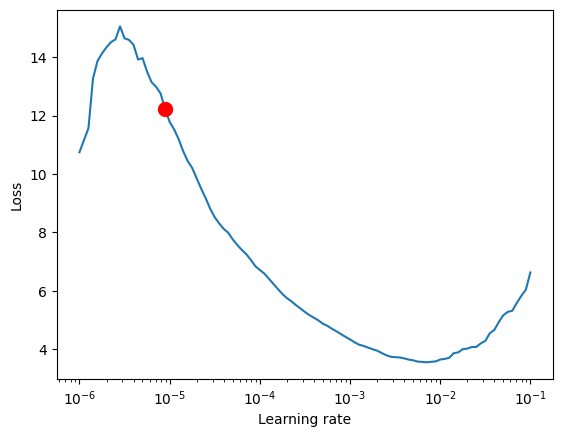

In [29]:
if True:
    tuner = Tuner(trainer)

    lr_finder = tuner.lr_find(
        tapas_lightning,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
        min_lr=1e-6,
        max_lr=1e-1,
        early_stop_threshold=None,
    )

    # Retrieve the suggested learning rate.
    new_lr = lr_finder.suggestion()
    print(f"Suggested learning rate: {new_lr}")

    fig = lr_finder.plot(suggest=True)
    fig.show()
else:
    # new_lr = 3.5481338923357546e-06
    # new_lr = 0.00035481338923357554
    new_lr = 8.912509381337456e-06


if new_lr:
    tapas_lightning.hparams.learning_rate = new_lr
    tapas_lightning.learning_rate = new_lr

In [50]:
# new_lr = 8.912509381337456e-06
new_lr = 5e-5


if new_lr:
    tapas_lightning.hparams.learning_rate = new_lr
    tapas_lightning.learning_rate = new_lr

In [51]:
# Start training.
trainer.fit(
    tapas_lightning, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params | Mode
-----------------------------------------------------------
0 | model | TapasForQuestionAnswering | 110 M  | eval
-----------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.706   Total estimated model params size (MB)
0         Modules in train mode
237       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [140]:
!ls $checkpoint_path

'tapas-epoch=00-val_loss=0.48.ckpt'	'tapas-epoch=00-val_loss=3.74.ckpt'
'tapas-epoch=00-val_loss=0.52.ckpt'	'tapas-epoch=01-val_loss=3.75.ckpt'
'tapas-epoch=00-val_loss=0.55.ckpt'	'tapas-epoch=02-val_loss=3.76.ckpt'
'tapas-epoch=00-val_loss=0.55-v1.ckpt'	'tapas-epoch=07-val_loss=3.74.ckpt'
'tapas-epoch=00-val_loss=0.99.ckpt'


In [202]:
# fitted_model = TapasLightningModule.load_from_checkpoint(
#     str(checkpoint_path / "tapas-epoch=00-val_loss=0.48.ckpt"),
#     model=tapas_model,
# )

# fitted_model.eval()

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [81]:
tapas_lightning.model.push_to_hub("tapas-finetuned-probas-supervised-2")

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/woranov/tapas-finetuned-probas-supervised-2/commit/e13b31912d686f678576f1cc7a6ed134499c3b56', commit_message='Upload TapasForQuestionAnswering', commit_description='', oid='e13b31912d686f678576f1cc7a6ed134499c3b56', pr_url=None, repo_url=RepoUrl('https://huggingface.co/woranov/tapas-finetuned-probas-supervised-2', endpoint='https://huggingface.co', repo_type='model', repo_id='woranov/tapas-finetuned-probas-supervised-2'), pr_revision=None, pr_num=None)

In [ ]:
from_hub_tokenizer = TapasTokenizer.from_pretrained(
    "google/tapas-base-finetuned-wikisql-supervised"
)
from_hub_model = TapasForQuestionAnswering.from_pretrained(
    "woranov/tapas-finetuned-probas-supervised-2"
)

config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [201]:
# model = fitted_model.model.to(device)
model = tapas_lightning.model.to(device)
# model = from_hub_model.to(device)

ex = examples_batched_df.iloc[int(len(examples_batched_df) * 0.8) :].sample(1).iloc[0]
question_general = ex["question_general"]
question_process_agnostic = ex["question_template"].replace("<", "").replace(">", "")
# question_process_agnostic = question_general

flows_df = get_flows_df(ex["process_uuid"]).sample(
    frac=1, random_state=ex["shuffle_seed"]
)

flows_df = flows_df.iloc[ex["flows_start"] : ex["flows_stop"]].reset_index(drop=True)
table = transform_flows_for_tapas(flows_df).astype(str)

queries = question_process_agnostic

display(table)
print(queries)

inputs = tapas_tokenizer(
    table=table, queries=queries, padding="max_length", return_tensors="pt"
)
with torch.no_grad():
    outputs = model(**inputs.to(device))
    predicted_answer_coordinates, predicted_aggregation_indices = (
        tapas_tokenizer.convert_logits_to_predictions(
            inputs.to("cpu"),
            outputs.logits.detach().to("cpu"),
            outputs.logits_aggregation.detach().to("cpu"),
            cell_classification_threshold=0.3,
        )
    )

# let's print out the results:
id2aggregation = {0: "NONE", 1: "SUM", 2: "AVERAGE", 3: "COUNT"}
aggregation_predictions_string = [
    id2aggregation[x] for x in predicted_aggregation_indices
]

print(aggregation_predictions_string)
print(predicted_answer_coordinates[0])

print(list(map(tuple, ex["coordinates"])))

,Direction,Amount,Type,Class,Name,Property,Unit
0,Output,1000.0,Product flow,Systems / Other systems,"Kupfer, sekundär",Mass,kg
1,Output,1.66,Elementary flow,Emissions / Emissions to water / Emissions to ...,biological oxygen demand,Mass,kg
2,Output,0.0,Elementary flow,Emissions / Emissions to air / Emissions to ai...,polycyclic aromatic hydrocarbons,Mass,kg
3,Input,6.809,Elementary flow,Resources / Resources from water / Renewable m...,water,Volume,m3
4,Output,0.01,Elementary flow,Emissions / Emissions to water / Emissions to ...,nitrate,Mass,kg
5,Output,0.0,Elementary flow,Emissions / Emissions to air / Emissions to ai...,"1,1,1-trichloroethane",Mass,kg
6,Output,0.112,Elementary flow,Emissions / Emissions to water / Emissions to ...,"nitrogen, total (excluding N2)",Mass,kg
7,Output,0.114,Elementary flow,Emissions / Emissions to air / Emissions to ai...,copper,Mass,kg
8,Output,11.8,Elementary flow,Emissions / Emissions to water / Emissions to ...,sulfate,Mass,kg
9,Output,0.005,Elementary flow,Emissions / Emissions to air / Emissions to ai...,chromium,Mass,kg


What is the total input amount of land use associated with the process?
['SUM']
[]
[]
